In [18]:
from db_utils import RDSDatabaseConnector, load_credentials
from format import DataFormat
import pandas as pd
from plotter import Plotter
from transform import DataFrameTransform
from db_utils import load_data
from info import DataFrameInfo
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

######################################
# Database
# Extract data and save to csv
######################################
# cred_dict = load_credentials()
# rds_con = RDSDatabaseConnector(cred_dict)
# df = rds_con.extract_rds_dataframe('loan_payments')
# RDSDatabaseConnector.save_to_csv(df, "loan_data.csv")
# RDSDatabaseConnector.csv_to_excel('loan_data')

Dataframe Shape:
(54231, 44)
                                % Null
funded_amount                 5.544799
term                          8.799395
int_rate                      9.531449
employment_length             3.905515
mths_since_last_delinq       57.166565
mths_since_last_record       88.602460
last_payment_date             0.134609
next_payment_date            60.127971
last_credit_pull_date         0.012908
collections_12_mths_ex_med    0.094042
mths_since_last_major_derog  86.172116


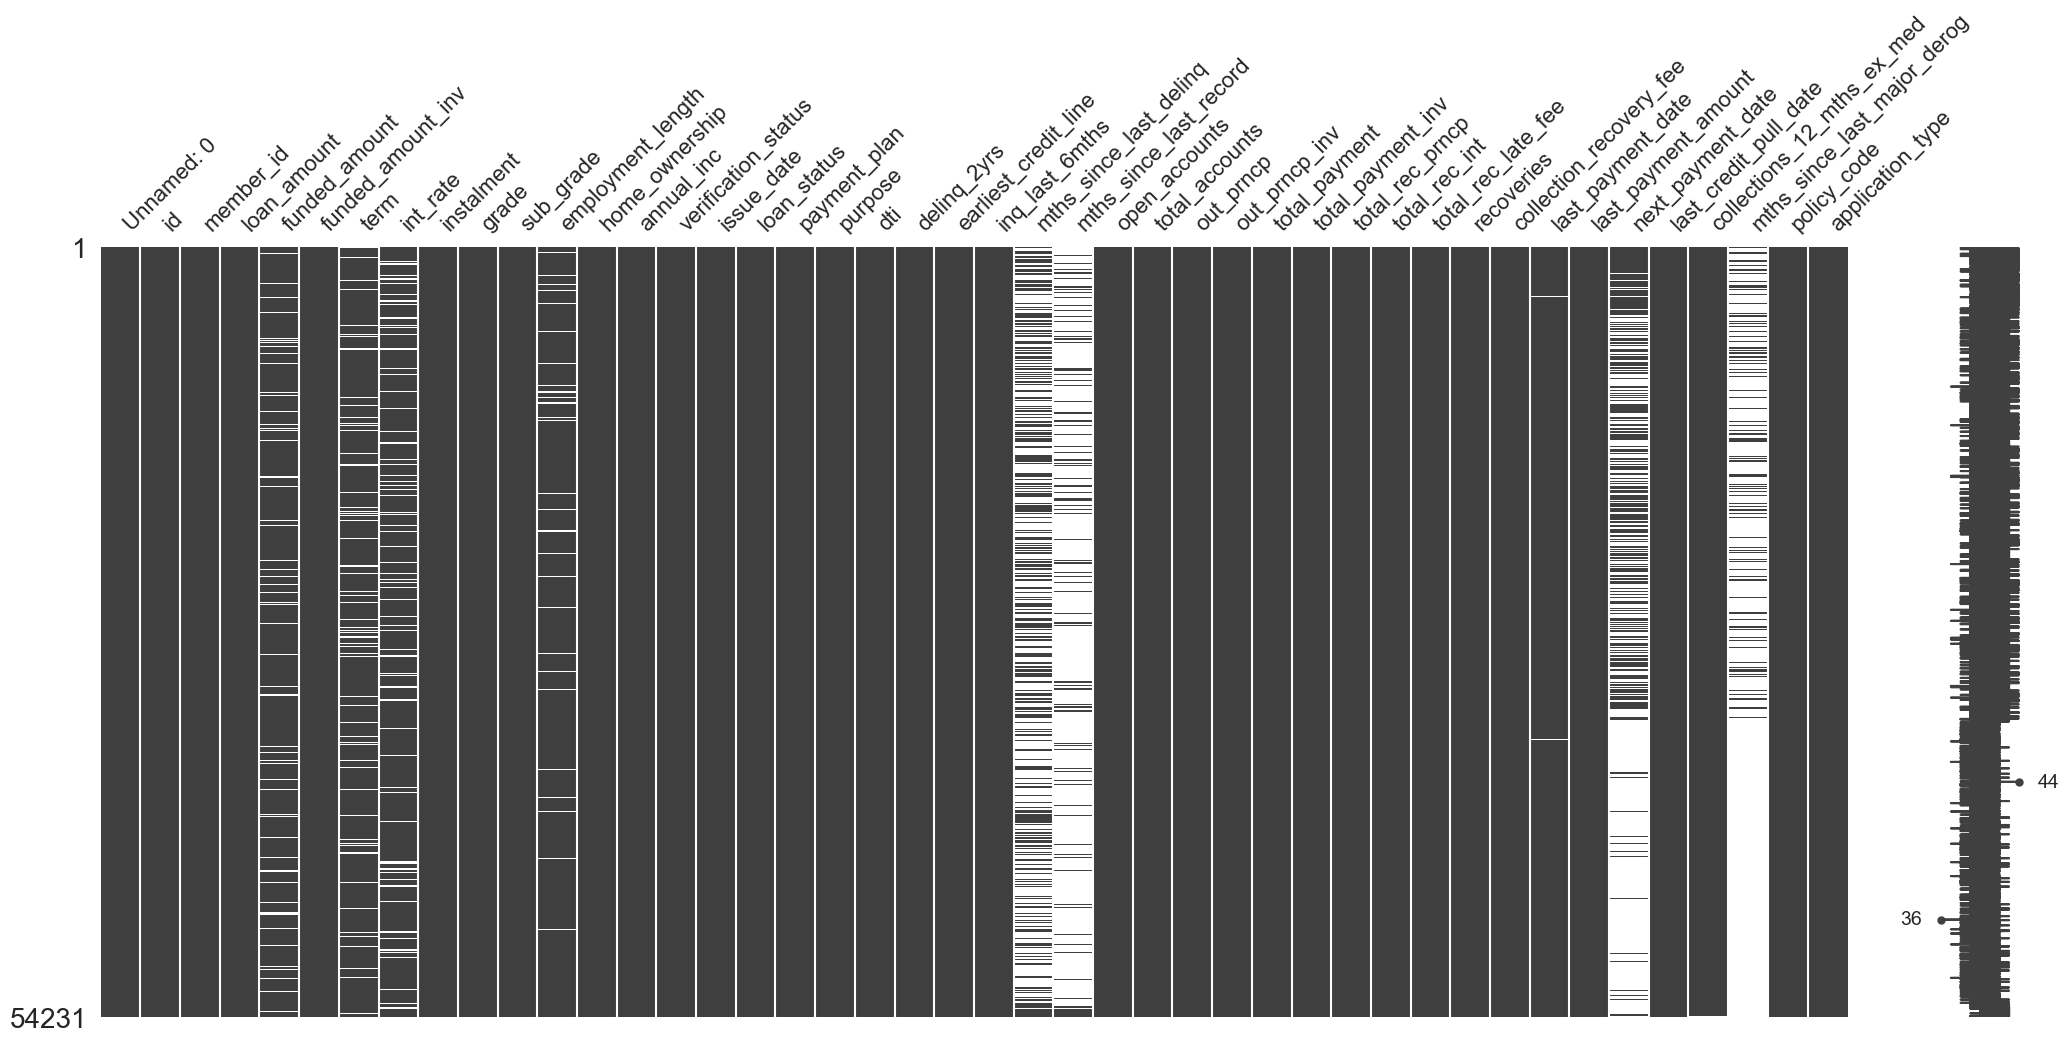

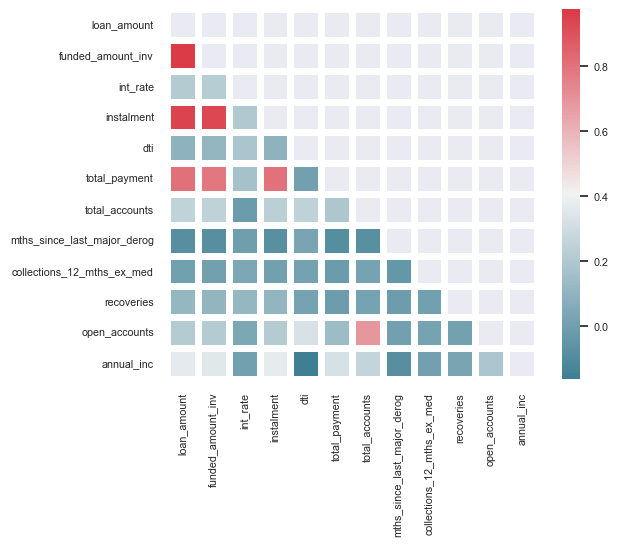

In [19]:
#######################################
# Info
# Understand the dataframe shape, missing percentages and statistics, and missing values
#######################################
df = load_data("/dataset/loan_data.csv")
Info = DataFrameInfo(df)

print(Info.get_shape())
print(Info.percentage_null())

plt = Plotter(df)

numerical_cols = ['loan_amount',
                  'funded_amount_inv', 'int_rate', 'instalment', 'dti', 'total_payment', 'total_accounts', 'mths_since_last_major_derog', 'collections_12_mths_ex_med', 'recoveries', 'open_accounts', 'annual_inc']

plt.missing_nulls_vis()
# MCAR
# 1. mths_since_last_major_derog   86.17 half of the data from vis is MCAR from cutoff point
# 2. sub_grade is MCAR
# 3. term is MCAR because loans must have terms and also its uncorrelated to other nulls missing vals from first look

# NMAR
# 1. inq_last months
# 2. last_payment
# 3. collections_12_mths_ex_med
# 4. employment length
# These values have no entry to signify no record eg. employment length = null because of no employment

###########################################################################
# Term
# Derog is serious delinquency of 30+ days vs delinq = failure to pay on time
###########################################################################

In [20]:
# As we can see there is small correlation between any of the numerical columns
# KNN imputation for missing values wouldn't be optimal because of no multi-variate columns to attatch to
print(Info.describe_columns())

Unnamed: 0                       int64
id                               int64
member_id                        int64
loan_amount                      int64
funded_amount                  float64
funded_amount_inv              float64
term                            object
int_rate                       float64
instalment                     float64
grade                           object
sub_grade                       object
employment_length               object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_date                      object
loan_status                     object
payment_plan                    object
purpose                         object
dti                            float64
delinq_2yrs                      int64
earliest_credit_line            object
inq_last_6mths                   int64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_accounts            

In [21]:
Transformer = DataFormat(df)
# Convert n and y to bool values
Transformer.string_to_boolean('payment_plan')

[ True]


In [22]:
# String dates to date format
string_dates = ['last_credit_pull_date', 'next_payment_date',
                'last_payment_date', 'earliest_credit_line', 'issue_date']

Transformer.strings_to_dates(string_dates)

In [23]:
# Cols to num
string_to_num_cols = ['term', 'employment_length']
numerical_cols = ['term', 'mths_since_last_record',
                  'mths_since_last_major_derog', 'mths_since_last_delinq', 'mths_since_last_record', 'delinq_2yrs']

# Month to intiger
Transformer.extract_num_from_string(string_to_num_cols)
Transformer.numerical_cols(numerical_cols)

# we don't convert these cols : 'mths_since_last_record', 'mths_since_last_major_derog' to int since they include 0 months since last to signify recent entry and null for NO entry
Transformer.to_int(['term', 'open_accounts', 'total_accounts',
                    'collections_12_mths_ex_med', 'delinq_2yrs', 'employment_length'])

Transformer.round_float('collection_recovery_fee', 2)

In [24]:
# Before we convert to category columns we manage unique case with NMCAR null values

# Before we convert categories we have to handle unique case of columns:
# mths_since_last_delinq 57.17
# mths_since_last_record 88.60
# mths_since_last_major_derog  86.17

bins = [np.nan, 0, 36, 72, 108, 146]
bin_labels = ['Never', '1-3 Years',
              '4-6 Years', '7-9 Years', '10-12 Years']

bin_cols = ['mths_since_last_delinq', 'mths_since_last_record',
            'mths_since_last_major_derog']

for col in bin_cols:
    Transformer.df[col] = pd.cut(Transformer.df[col], bins=bins,
                                 labels=bin_labels, right=True, include_lowest=True)
    Transformer.df[col] = Transformer.df[col].fillna('Never')

categories = ['grade', 'sub_grade', 'home_ownership',
              'verification_status', 'loan_status', 'purpose', 'employment_length']

Transformer.cols_to_categories(categories)
Transformer.cols_to_categories(bin_cols)

# next_payment_date 60.13

In [25]:
# funded_amount seems to have more "nulls" according to .info() meaning that it has missing unexplained values that funded_amount_inv picks up on
# application and policy code have all same values across whole column
# out_prncp_inv/total_payment_inv is the same as out_prncp/total_payment
# next_payment_date doesn't seem useful to us since there are a lot missing (possibly NMAR because suggest payed off loan)

Transformer.df.head()

drop_cols = ['funded_amount', 'application_type',
             'policy_code', 'out_prncp_inv', 'total_payment_inv', 'Unnamed: 0', 'id', 'next_payment_date'
             ]
Transformer.drop_cols(drop_cols)

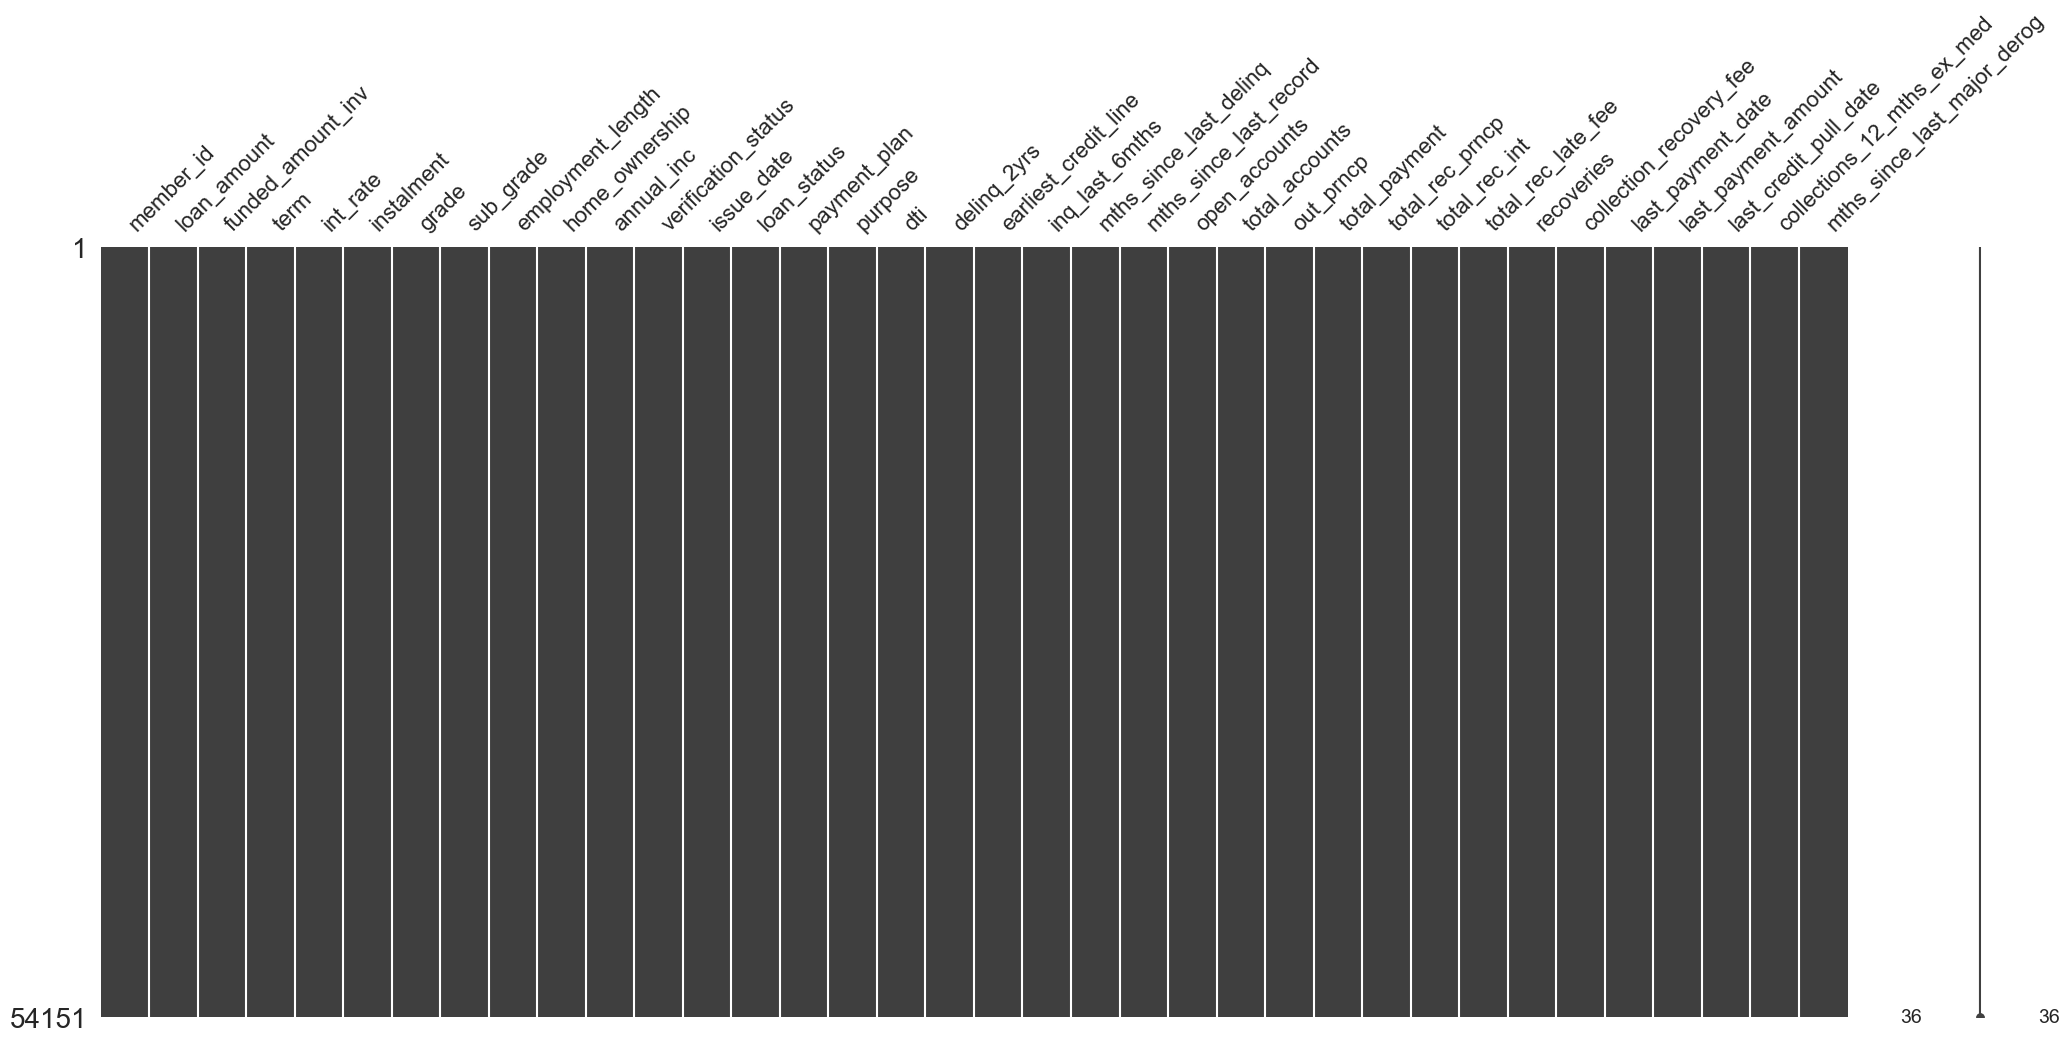

0    1-3 Years
1        Never
2        Never
3        Never
4        Never
Name: mths_since_last_major_derog, dtype: category
Categories (5, object): ['Never' < '1-3 Years' < '4-6 Years' < '7-9 Years' < '10-12 Years']


In [26]:
# Impute and further drop
# NMAR
# missing employment length likely means unemployed so impute 0

t_form = DataFrameTransform(df)

# Assume When Employment length is missing it means they don't have a job
t_form.impute_zeros(['employment_length'])
# mean interest rate since its within normal dist
t_form.impute_median(['int_rate', 'loan_amount'])

# these rows have insignificant null vals
t_form.drop_null_rows(['last_payment_date', 'last_credit_pull_date'])
plt = Plotter(t_form.df)
plt.missing_nulls_vis()
print(df['mths_since_last_major_derog'].head())

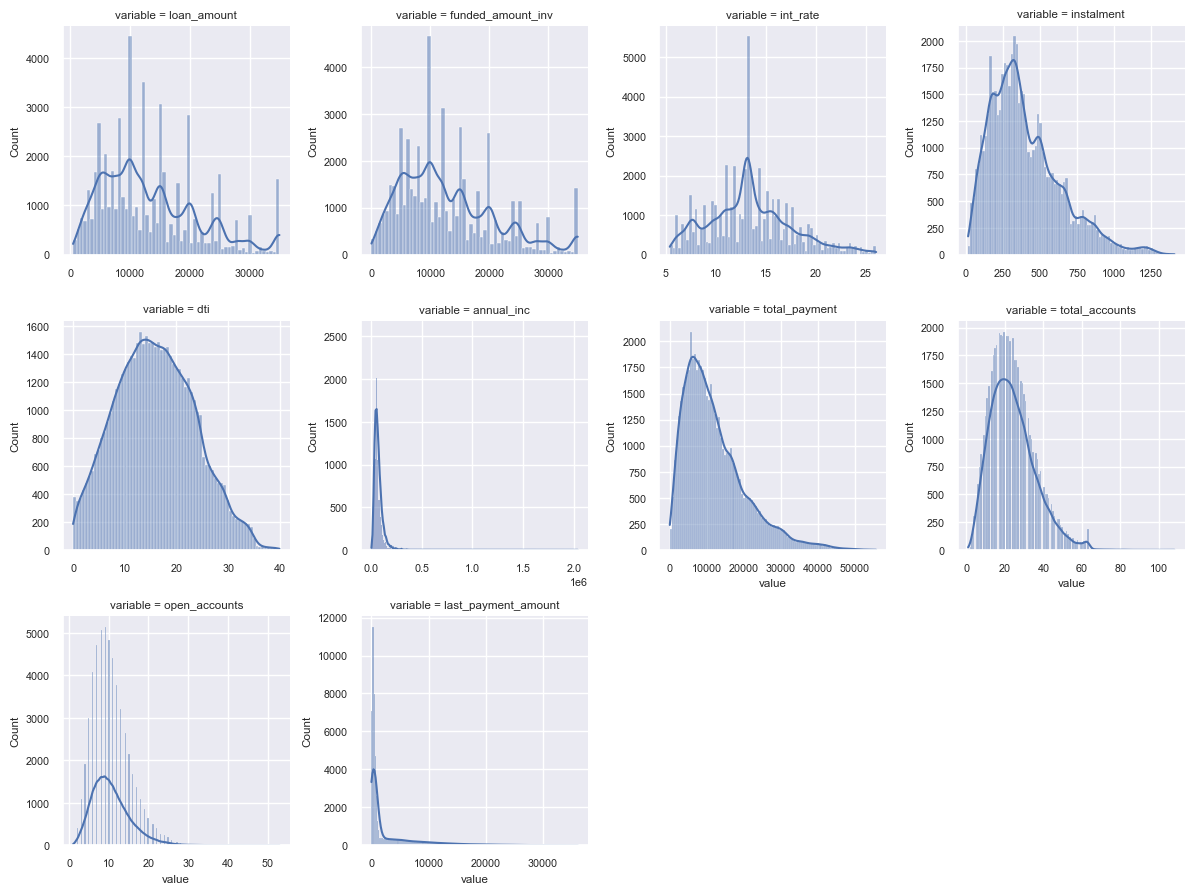

+---------------------+---------------------+
|       Column        |      Skewness       |
+---------------------+---------------------+
|     loan_amount     | 0.8049220181025606  |
|  funded_amount_inv  | 0.8133760835309213  |
|      int_rate       | 0.45661978102982004 |
|     instalment      | 0.9965721690437305  |
|         dti         | 0.18910057534680505 |
|     annual_inc      |  8.717494831349065  |
|    total_payment    | 1.2698752825756143  |
|   total_accounts    | 0.7790400286166349  |
|    open_accounts    | 1.0591835802494733  |
| last_payment_amount |  2.497220272729314  |
+---------------------+---------------------+


In [27]:

# delinq appears more discrete than continuous so we dont include in skew analysis
numerical_cols = ['loan_amount',
                  'funded_amount_inv', 'int_rate', 'instalment', 'dti', 'annual_inc', 'total_payment', 'total_accounts', 'open_accounts', 'last_payment_amount']

plt.multi_hist_plot(numerical_cols)
Info.skew_data(numerical_cols)

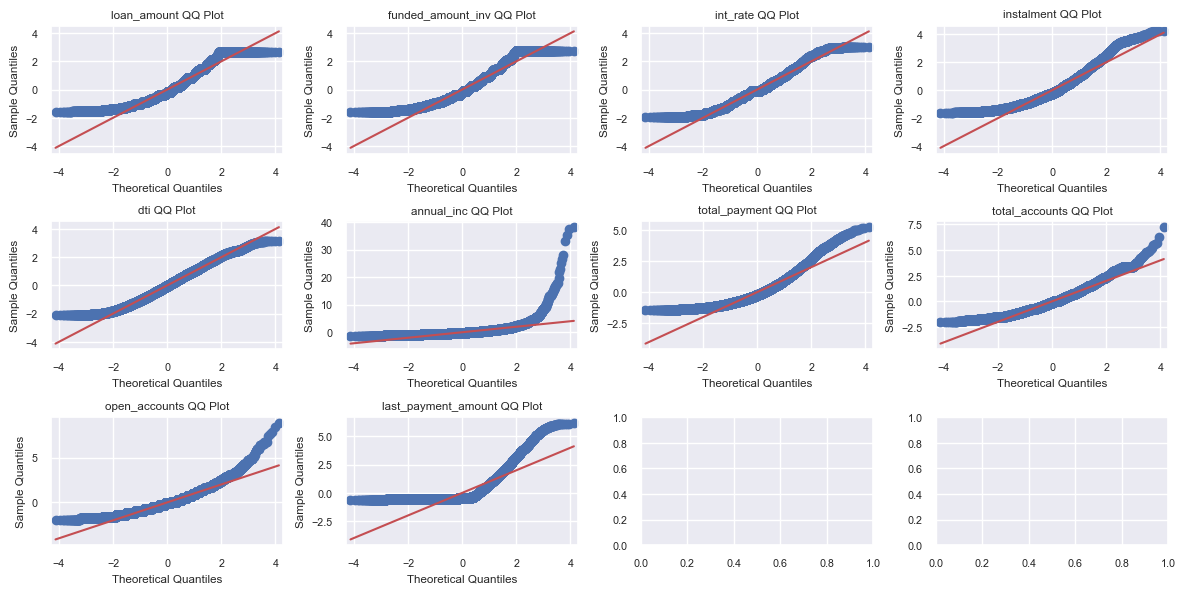

In [28]:
# All numerical data has high positive Skew

plt.multi_qq_plot(numerical_cols)

info = DataFrameInfo(t_form.df)

right_skewed_cols = ['annual_inc', 'total_payment', 'total_accounts',
                     'last_payment_amount', 'open_accounts', 'instalment', 'funded_amount_inv']

# As we can see the majority cols have almost exponential looking outliers

In [29]:
# Reduce impact of outliers
log_transform_cols = ['annual_inc', 'total_accounts',
                      'open_accounts', 'last_payment_amount']

t_form.log_transform(log_transform_cols)

+---------------------+----------------------+
|       Column        |       Skewness       |
+---------------------+----------------------+
|     loan_amount     |  0.8049220181025606  |
|  funded_amount_inv  |  0.8133760835309213  |
|      int_rate       | 0.45661978102982004  |
|     instalment      |  0.9965721690437305  |
|         dti         | 0.18910057534680505  |
|     annual_inc      | 0.13920278768499378  |
|    total_payment    |  1.2698752825756143  |
|   total_accounts    |  -0.678135510649571  |
|    open_accounts    | -0.47090032482861877 |
| last_payment_amount | 0.12803763161603252  |
+---------------------+----------------------+


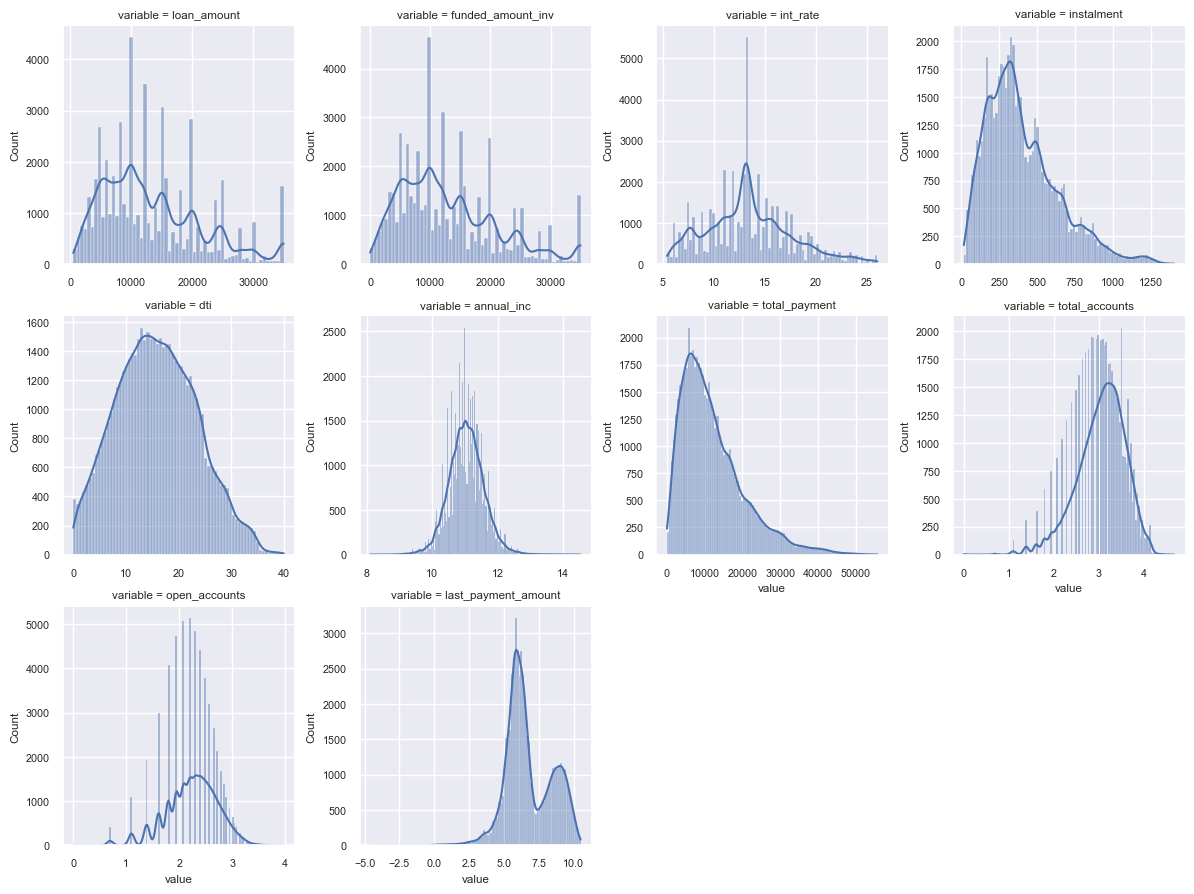

In [30]:
# Data looks a lot more normally distributed than before (weve corrected right skew and impact of outliers)
Info.skew_data(numerical_cols)
plt.multi_hist_plot(numerical_cols)

+-------------------+-----------------------+
|      Column       |       Skewness        |
+-------------------+-----------------------+
|    loan_amount    | -0.04307775783057989  |
|   total_payment   | -0.013814755711541862 |
|    instalment     | -0.020712390195657807 |
|     int_rate      | -0.01335284004413076  |
|        dti        |  -0.1257174261979297  |
| funded_amount_inv | -0.052400985331818334 |
+-------------------+-----------------------+
Saving to CSV in dir: c:\Users\prote\exploratory-data-analysis---customer-loans-in-finance/dataset/transformed_data.csv
Completed Save


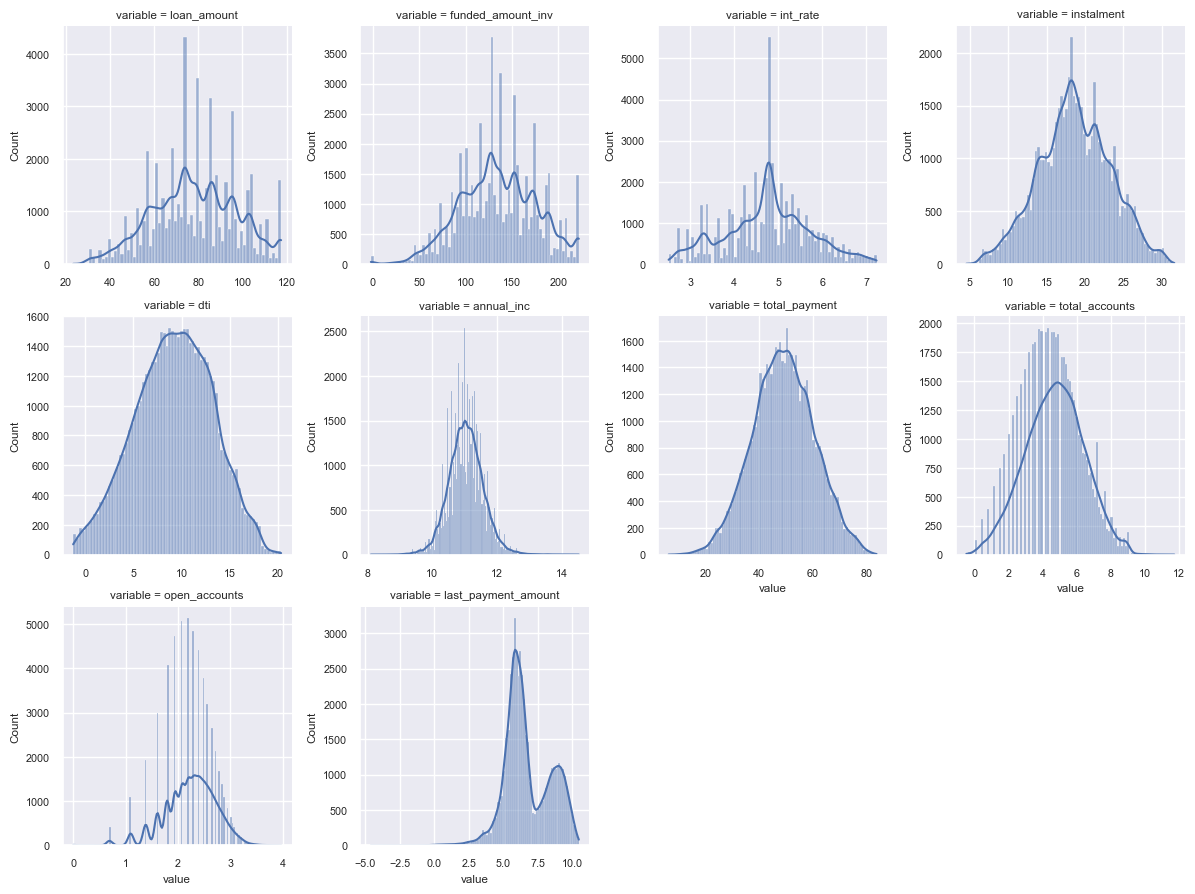

In [31]:
# Now the skew values are closer to 0 and we can apply
# Box cox transform
t_form.box_cox_transform(
    ['loan_amount', 'instalment', 'int_rate', 'total_accounts', 'dti', 'funded_amount_inv', 'total_payment'])

Info.skew_data(
    ['loan_amount', 'total_payment', 'instalment', 'int_rate', 'dti', 'funded_amount_inv'])

RDSDatabaseConnector.save_to_csv(t_form.df, "transformed_data.csv")
plt.multi_hist_plot(numerical_cols)

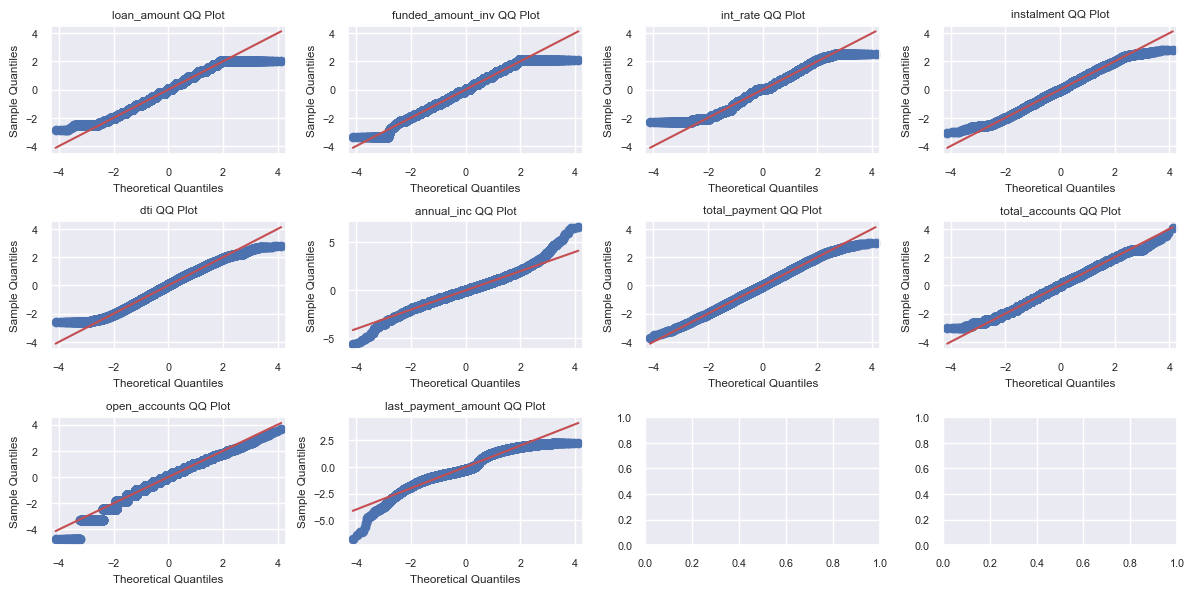

In [32]:
plt.multi_qq_plot(numerical_cols)

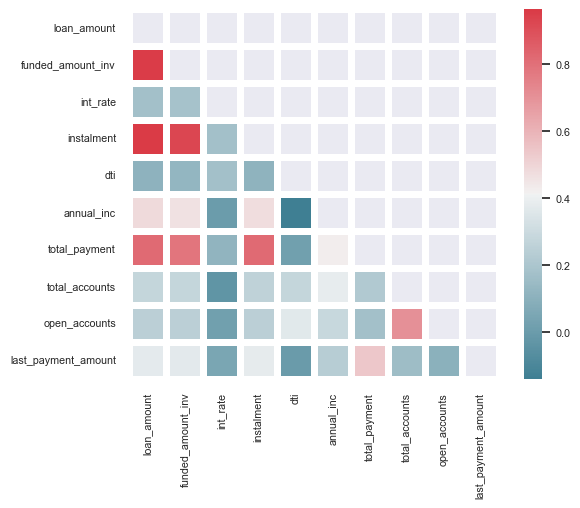

22.356420281174497


In [49]:
import statsmodels.formula.api as smf

plt.correlated_vars(numerical_cols)
# funded_amount / loan_amount

# instalment / loan_amount

# instalment / total_payment

model0 = smf.ols("loan_amount ~ instalment + funded_amount_inv", plt.df).fit()


def VIF(r2):
    return 1/(1-r2)


print(VIF(model0.rsquared))
Transformer.drop_cols(['instalment', 'funded_amount_inv'])